In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import matplotlib

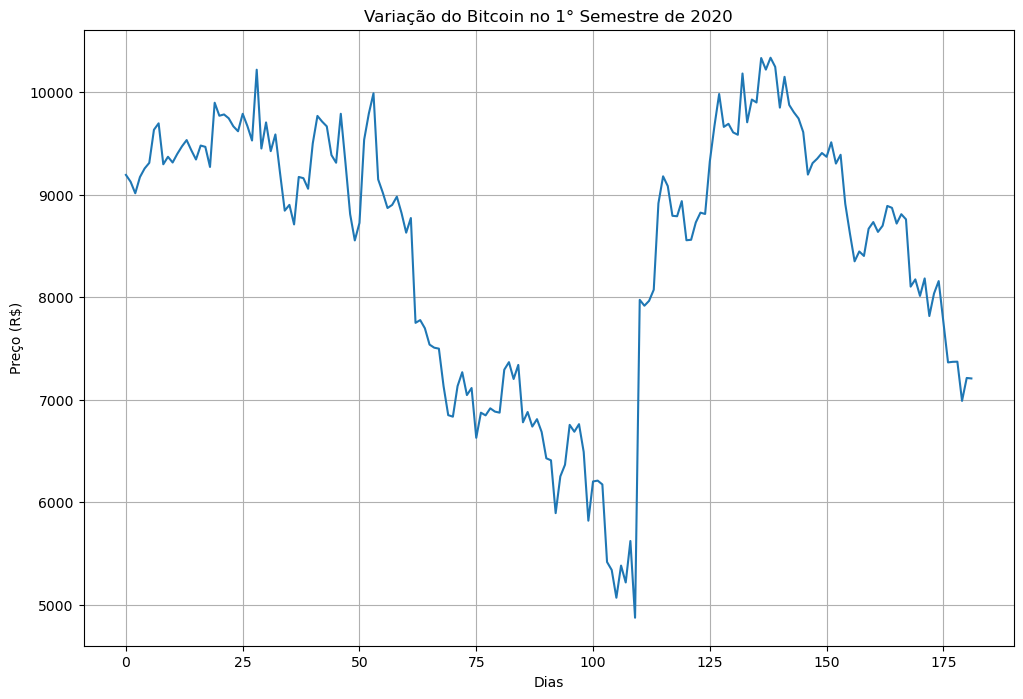

In [2]:
#Carrega a série de dados temporais (Preço de abertura do Bitcoin no primeiro semetres de 2020)
df = pd.read_csv('Datasets/dados_btc.csv')
serie_btc = df['Abertura']

plt.figure(dpi=100, figsize=(12, 8))
plt.title('Variação do Bitcoin no 1° Semestre de 2020')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.plot(serie_btc)
plt.grid()
plt.show()

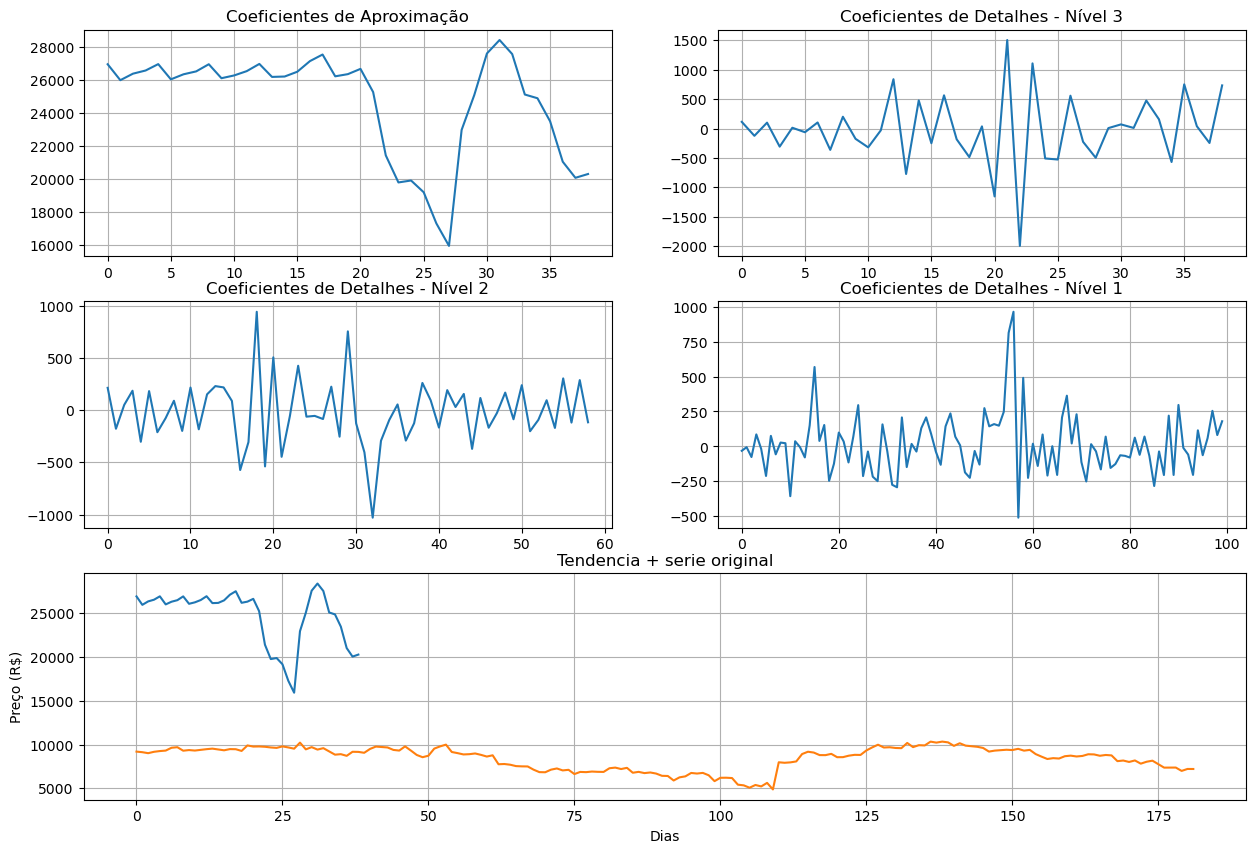

In [18]:
#Implementa a DWT (PyWavelets)
import pywt

wavelet = pywt.Wavelet('db10')
coeffs_approx  = pywt.wavedec(serie_btc, wavelet, level=3) # dec de deconstruction

#Mostra o último nível de aproximação
fig = plt.figure(dpi=100,figsize=(15,10))
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

ax1.plot(coeffs_approx[0]) # Ultimo nivel 
ax1.set_title('Coeficientes de Aproximação')
ax1.grid()

ax2.plot(coeffs_approx[1])
ax2.set_title('Coeficientes de Detalhes - Nível 3')
ax2.grid()

ax3.plot(coeffs_approx[2])
ax3.set_title('Coeficientes de Detalhes - Nível 2')
ax3.grid()

ax4.plot(coeffs_approx[3])
ax4.set_title('Coeficientes de Detalhes - Nível 1')
ax4.grid()

ax5.plot(coeffs_approx[0])
ax5.plot(serie_btc)
ax5.set_ylabel('Preço (R$)')
ax5.set_xlabel('Dias')
ax5.set_title('Tendencia + serie original')
ax5.grid()

plt.show()

Eu não posso usar o coefficient que representaria a tendencia do jeito que está. Eu tenho que fazer um upsampling dele apos remover os coefficientes de detalhe

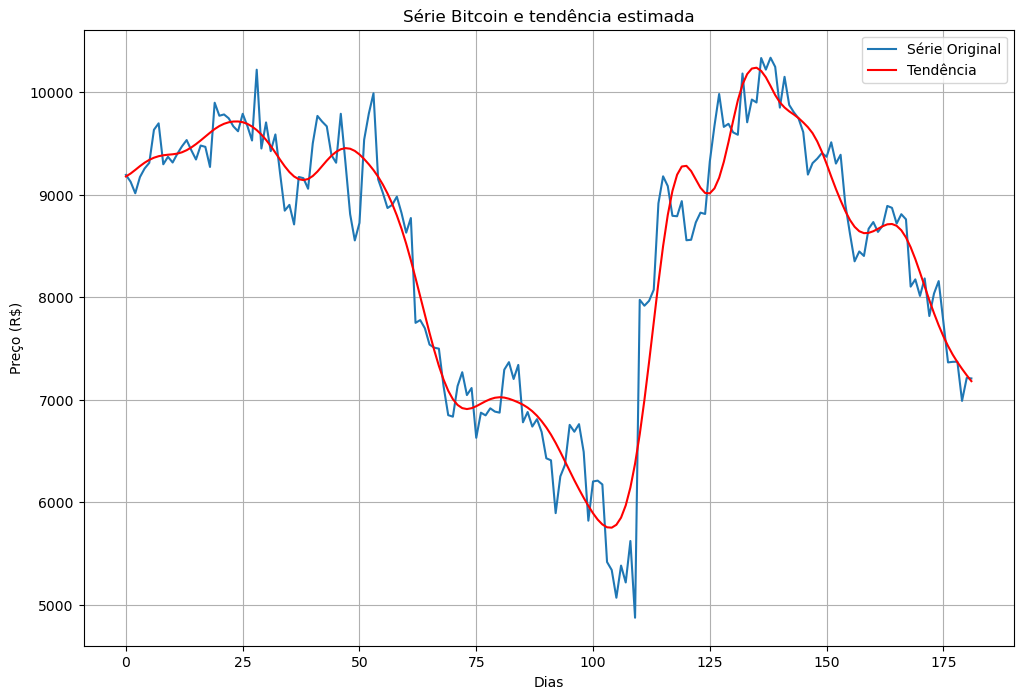

In [21]:
#Sintetiza (reconstrói) a série sem os coeficientes de detalhes
for j in range(1, len(coeffs_approx)):
    coeffs_approx[j] *= 0

tendencia_estimada = pywt.waverec(coeffs_approx, wavelet) # rec de reconstrução

#exibe a série original e a serie reconstruída, que representa a tendência da série original,
#pois esta é a componente de baixa frequência

plt.figure(figsize=(12, 8))
plt.plot(serie_btc, label='Série Original')
plt.plot(tendencia_estimada, label='Tendência', color='red')
plt.title('Série Bitcoin e tendência estimada')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.legend()
plt.grid()
plt.show()


# Considerando a série com ruído branco

Neste exemplo verificamos como a curva de tendência é alterada caso se considera ruído branco adicionado a série original

In [26]:
#Cria um ruído branco
ruido = np.random.normal(0, 1, len(serie_btc))

serie_ruidosa_btc = serie_btc + ruido * 800

#Decompões o sinal pela DWT
wavelet = pywt.Wavelet('db10')
coeffs = pywt.wavedec(serie_ruidosa_btc, wavelet, level=3)

#Zera os coeficientes de detalhes
for j in range(1, len(coeffs)):
    coeffs[j] *= 0

#Sintetiza a série temporal com os coeficientes encolhidos
tendencia_estimada_ruidosa = pywt.waverec(coeffs, wavelet)

'''
Implementa uma média móvel apenas para comparação
'''
wz = 12  # tamanho da janela de análise
mv_ruidosa = pd.Series(serie_ruidosa_btc).rolling(wz).mean().tolist()
mv_ruidosa = mv_ruidosa[wz - 1: len(serie_ruidosa_btc) + wz]

#Implementa para a séria original sem ruído também
#A fim de verificar como o ruído afeta a estimação
mv = pd.Series(serie_btc).rolling(wz).mean().tolist()
mv = mv[wz - 1: len(serie_btc) + wz]

#Calcula o erro médio quadrático de estimação devido ao ruído
erro_dwt = (np.sum(np.abs(np.array(tendencia_estimada_ruidosa) -
            np.array(tendencia_estimada))**2))/len(tendencia_estimada_ruidosa)
erro_mv = (np.sum(np.abs(np.array(mv_ruidosa) - np.array(mv))**2))/len(mv)

print('Erros')
print('DWT: ', erro_dwt)
print('MV: ', erro_mv)


Erros
DWT:  45400.34815316305
MV:  32282.539805049633


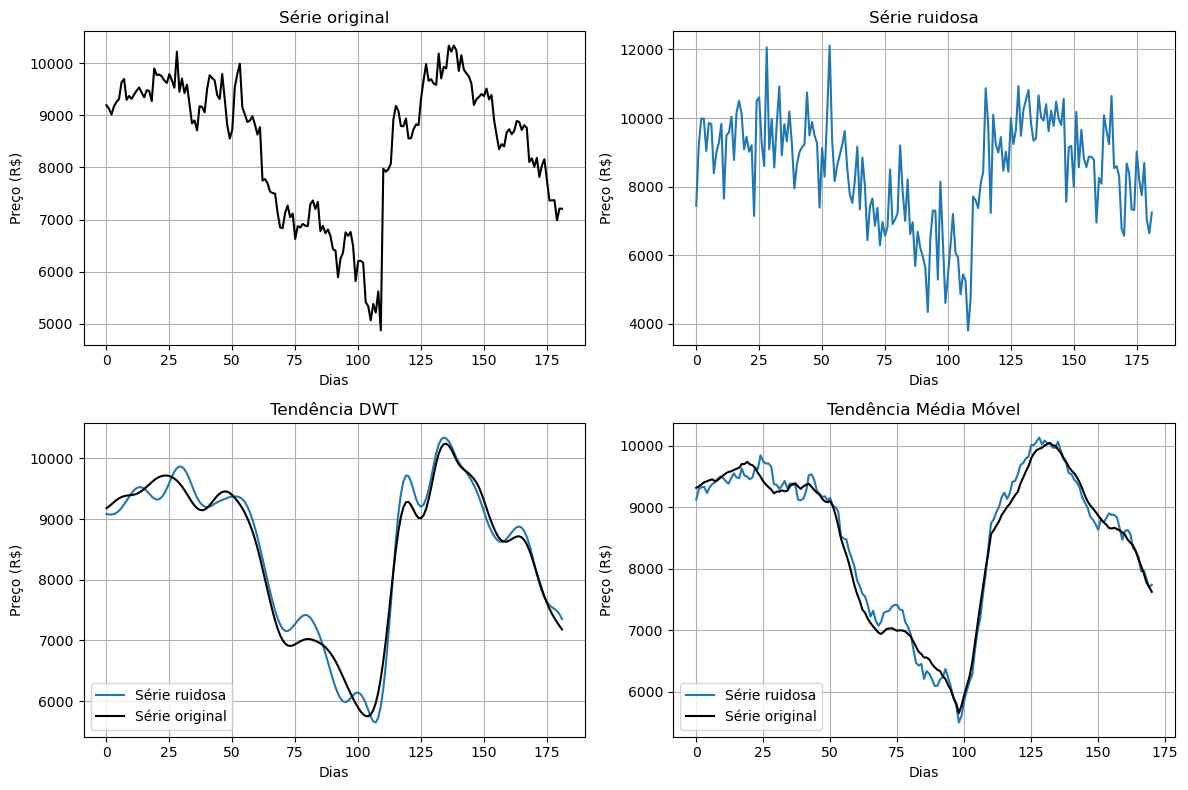

In [27]:
#exibe a série original e a serie reconstruída, que representa a tendência da série original,
#pois esta é a componente de baixa frequência
plt.figure(dpi=100, figsize=(12, 8))

plt.subplot(221)
plt.title('Série original')
plt.plot(serie_btc, color='k')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.grid()

plt.subplot(222)
plt.title('Série ruidosa')
plt.plot(serie_ruidosa_btc)
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.grid()

plt.subplot(223)
plt.title('Tendência DWT')
plt.plot(tendencia_estimada_ruidosa, label='Série ruidosa')
plt.plot(tendencia_estimada, color='k', label='Série original')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.legend()
plt.grid()

plt.subplot(224)
plt.title('Tendência Média Móvel')
plt.plot(mv_ruidosa, label='Série ruidosa')
plt.plot(mv, color='k', label='Série original')
plt.ylabel('Preço (R$)')
plt.xlabel('Dias')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()